# Stock Cluster Analysis  
### By: Ari Silburt
### Date: April 29th, 2017

In the management of a financial portfolio one important consideration is the correlations between the portfolio's various stocks. For example, in order to efficiently minimize risk it is important to diversify the stocks in a portfolio. For a well diversified portfolio, if a subset of stocks are suffering the entire portfolio does not suffer (or even compensates).

For this analysis we will make use of an unsupervised machine learning technique called <i>agglomerate hierarchical clustering</i>. This technique looks for clusters in a dataset without needing to know exactly what the meaning of these clusters are. As we will see, certain sectors are naturally more diversified than others. 

The full ipython notebook can be downloaded from my github repository <a href="https://github.com/silburt/Machine_Learning/blob/master/StockCorrelation.ipynb">here</a>.

## Functions
Below are the packages and functions that we will use for this Stock Cluster analysis. The following are a brief explanation of what the functions are doing.

### get_data()
Scrapes an index (e.g. S&P500, DJIA, etc.) from Yahoo finance using the pandas datareader. It uses the adjusted closing prices which are often used for analyses of this sort, and removes tickers within an index with over 50 NaN values.

### process_data()
Processing and preparation of the data is as important as the analysis itself. In this function are the options to scale, smooth and use the derivative of the data (studies seem to demonstrate that using the derivative of the closing prices is better). 

In [1]:
#Load relevant packages
import datetime
from pandas_datareader import data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [2]:
#Get data using the Yahoo datareader
def get_data(dataname, start_year):
    companies = pd.read_csv("csv/tickers_"+dataname+".csv")
    companies["Ticker"] = companies["Tickers"]
    companies = companies.set_index("Tickers")
    start_date, end_date = datetime.datetime(start_year, 1, 1), datetime.datetime.today()
    
    #get Adj Close prices (typically used for correlations) and clean
    data = web.DataReader(companies["Ticker"], 'yahoo', start_date, end_date)["Adj Close"];
    isnull = data.isnull().sum()
    for ticker in companies["Ticker"]:     #if too many null entries for given stock, exclude from analysis
        if isnull[ticker] > 50:
            data.drop(ticker, axis=1, inplace=True)
    return data, companies

def process_data(df, window_size, smooth, diff): 
    df = (df - df.median())/df.std()      #Scale Data
    dfscaled = df.copy()
    
    if smooth == 1:                       #Smooth Data
        df = df.rolling(window=window_size).mean()
        df = df[(window_size-1):]
        
    if diff == 1:                         #Get Derivative of data
        df = df.diff(axis=0)
        df = df[1:]
    return df, dfscaled

## Analysis
### Get Data
Let's analyze the S&PIT index, i.e. the stocks in the S&P 500 that are considered part of the Information Technology sector. Any idexes recognized by Yahoo Finance should be callable, you just need to get the relevant stock tickers and put them in a .csv file. <a href="https://github.com/silburt/Machine_Learning/blob/master/csv/tickers_DJIA.csv">Here</a> is an example.

In [15]:
index = "S&PIT"     #options are DJIA, S&PEnergy, S&PIT, etc.
start_year = 2015   #get data from start_year (Jan 1st) to today
window = 7          #rolling window for taking the mean Adj Close price

data, companies = get_data(index, start_year)
data, data_scaled = process_data(data, window, 1, 1)
data.head()

,AAPL,ACN,ADBE,ADI,ADP,ADS,ADSK,AKAM,AMAT,ATVI,...,TEL,TSS,TXN,V,VRSN,WDC,WU,XLNX,XRX,YHOO
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-13,0.009337,0.011496,-0.016541,-0.030316,0.011734,0.008643,-0.027148,-0.039388,-0.031984,-0.026680,...,-0.013127,-0.006998,-0.008884,-0.020744,-0.005624,-0.007500,-0.012242,-0.035934,-0.011046,-0.049874
2015-01-14,0.037242,0.016721,-0.018809,-0.015539,0.008673,-0.000119,-0.027892,-0.035705,-0.022369,-0.015634,...,0.022913,-0.005598,0.000773,-0.017662,0.000444,-0.001429,-0.046143,-0.029363,0.033139,-0.043206
2015-01-15,0.005875,0.016953,-0.002268,-0.007922,0.019727,0.007255,-0.022190,-0.032663,0.001570,-0.015804,...,0.027686,-0.001633,0.007854,-0.021380,0.005772,-0.013143,-0.068743,-0.023408,0.014728,-0.079478
2015-01-16,-0.018464,0.004180,0.005860,-0.001828,0.022278,0.038059,-0.006570,-0.015051,0.000000,0.020222,...,0.000477,0.010264,0.007468,-0.029355,0.015095,-0.012643,-0.032017,-0.020123,0.019638,-0.056542
2015-01-20,-0.033256,-0.014631,-0.013516,-0.005637,-0.003401,0.021210,-0.021074,-0.030742,-0.011577,0.016484,...,-0.052746,-0.007698,0.003090,-0.037232,-0.010655,-0.027072,-0.084752,-0.042710,-0.038048,-0.069343


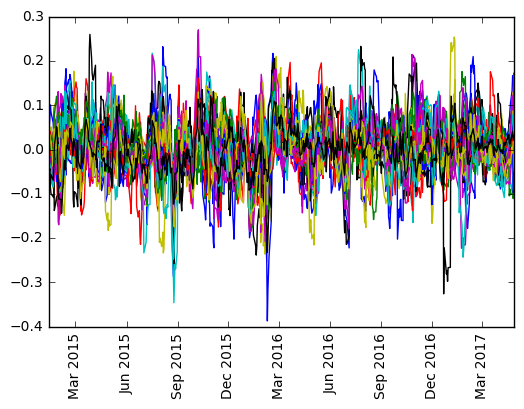

In [16]:
#A messy plot of all the processed adjusted closing prices
%matplotlib inline
plt.plot(data);
plt.xticks(rotation='vertical');

### Distance Measure for clustering
In order to cluster the stocks we need an inherest distance measurement. The most popular one which we will use is the standard correlation coefficient:

<h3 align="center"> $\rho(x,y) = \frac{cov(x,y)}{\sigma_x \sigma_y} $ </h3>

Other distance measures can be used, like Maximal Information Compression Index, Least Square Regression Error, etc.

In the correlation matrix plotted below, red/blue colours indicate high/low correlation. You will notice a perfect 1:1 correlation along the diagonal as expected (all stocks have a perfect correlation with themselves).

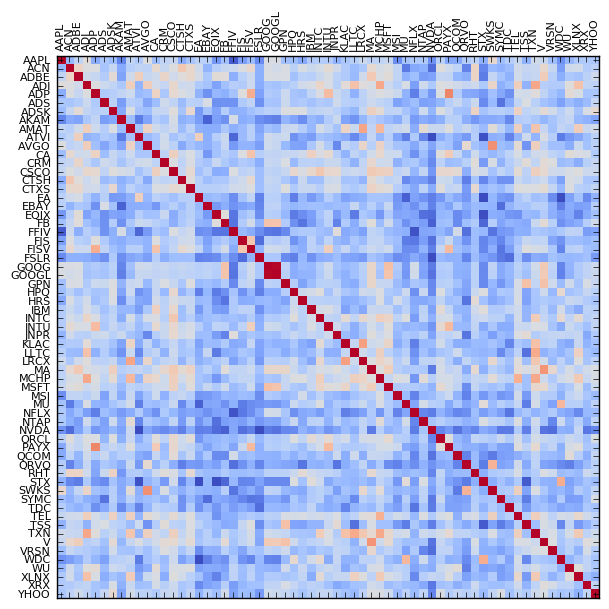

In [17]:
#find correlation matrix, i.e. the "distances" between each stock
corr = data.corr()
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);

### Clusters of Correlation - Agglomerate
The next step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. Its primary advantage over other clustering methods is that you don't need to guess in advance how many clusters there might be. Agglomerate Clustering first assigns each data point into its own cluster, and gradually merges clusters until only one remains. It's then up to the user to choose a cutoff threshold and decide how many clusters are present.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

There are also different options for the measurement of the distance. The option we will choose is the average distance measurement, but others are possible (ward, single, centroid, etc.). 

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(corr, 'average')
Z[0]

array([ 24.        ,  25.        ,   0.11139373,   2.        ])

### Cophenetic Correlation coefficient
It's important to get a sense of how well the clustering performs. One measure is the Cophenetic Correlation Coefficient, $c$. This compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer $c$ is to 1, the better the clustering preserves the original distances. Generally  $c$ > 0.7 is consistered a good cluster fit. Of course, other accuracy checks are possible.

In [19]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab
c, coph_dists = cophenet(Z, pdist(corr))
c

0.70486961126559944

### Dendogram
The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

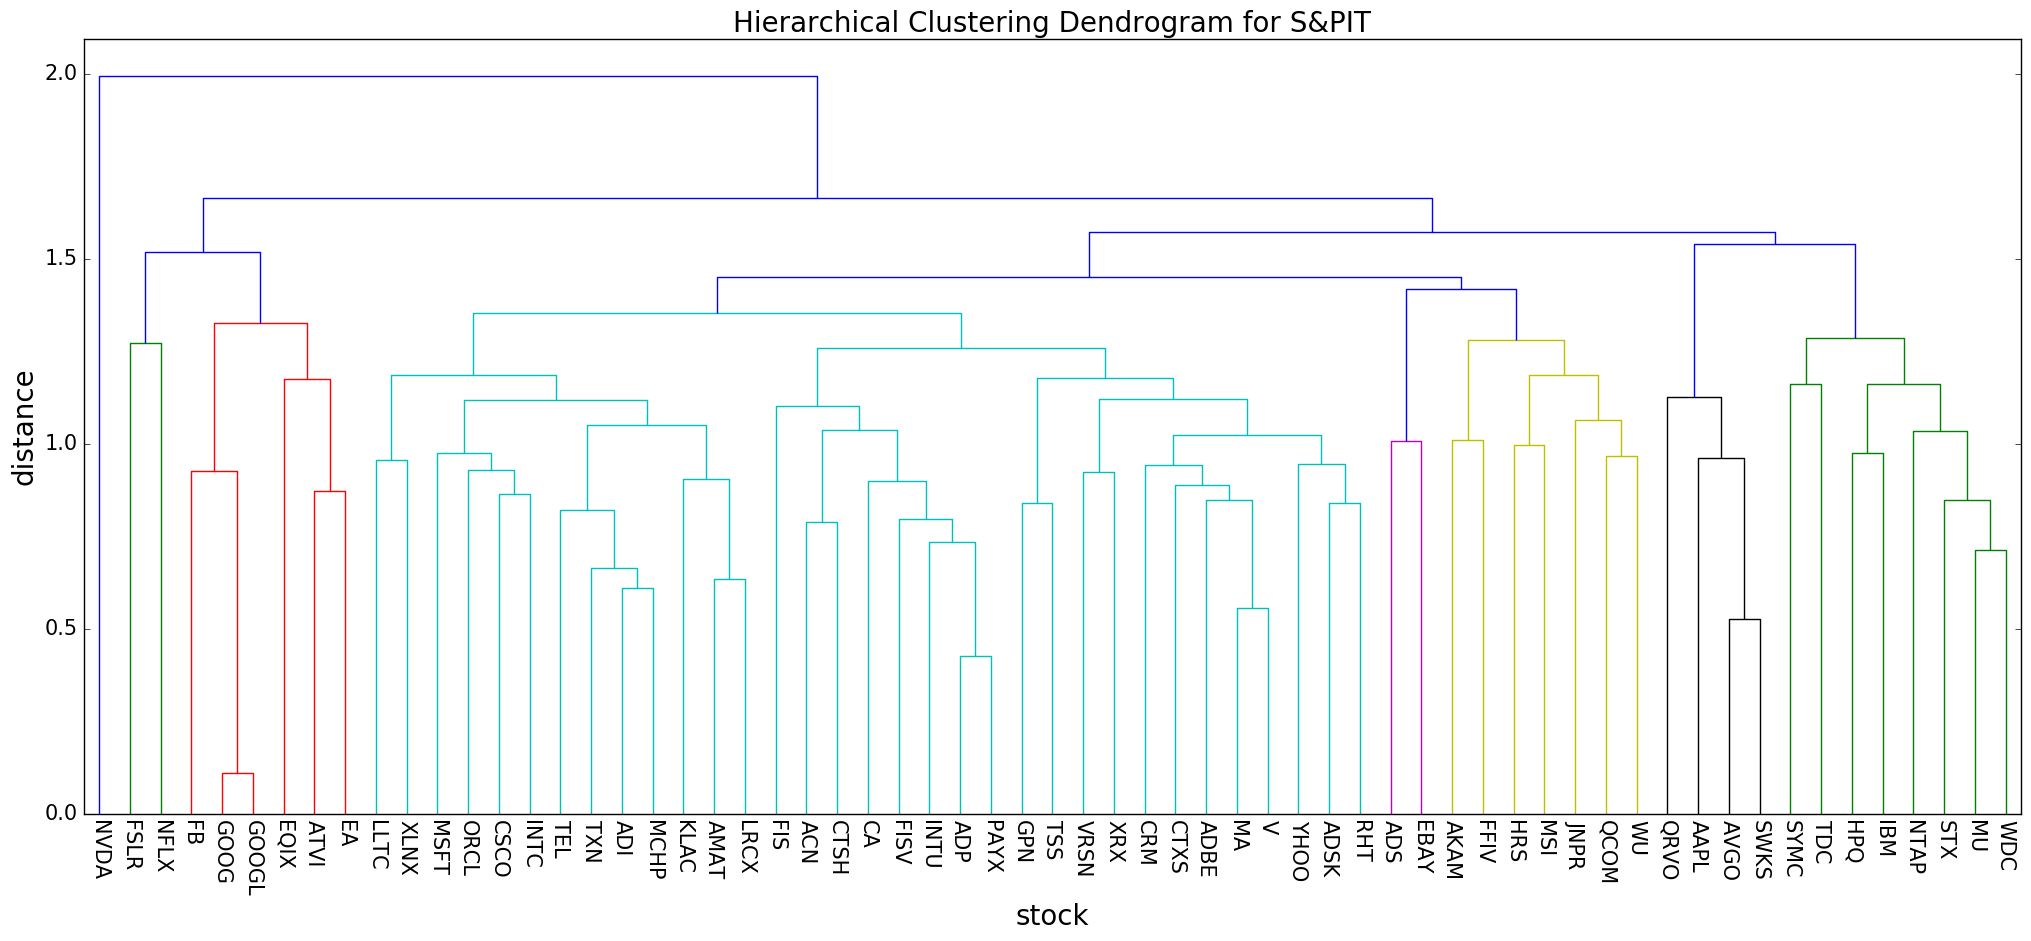

In [20]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for '+index, fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.savefig('img/dendogram_'+index+'.png')
plt.show()

According to the dendogram above, the two most correlated stocks (besides GOOGL and GOOG, which we'll ignore) PAYX and ADP. First, does this intuitively make sense? Doing a quick look at <a href="https://www.paychex.com/">PAYX</a> and  <a href="https://www.adp.com/">ADP</a>, it seems like they are both in the business of taxes, payroll, HR, retirement and insurance. So it makes sense that they would be strongly correlated. Let's plot them below to visually see how well they correlate. In addition, let's pick two stocks that are not well correlated at all to compare to, say, NVDA and WDC. 

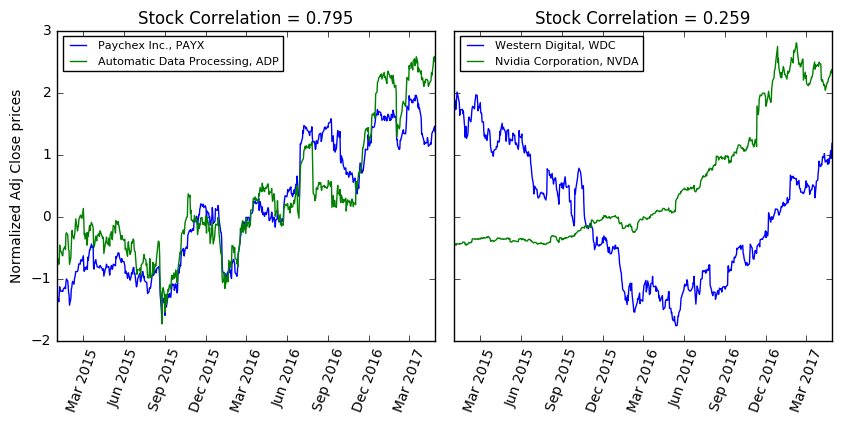

In [20]:
#plot sample correlations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
plt.subplots_adjust(wspace=0.05)

#high correlation
sA = "PAYX"
sB = "ADP"
ax1.plot(data_scaled[sA],label=companies["Name"].ix[sA]+', '+sA)
ax1.plot(data_scaled[sB],label=companies["Name"].ix[sB]+', '+sB)
ax1.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax1.set_ylabel('Normalized Adj Close prices')
ax1.legend(loc='upper left',prop={'size':8})
plt.setp(ax1.get_xticklabels(), rotation=70);

#low correlation
sA = "WDC"
sB = "NVDA"
ax2.plot(data_scaled[sA],label=companies["Name"].ix[sA]+', '+sA)
ax2.plot(data_scaled[sB],label=companies["Name"].ix[sB]+', '+sB)
ax2.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax2.legend(loc='upper left',prop={'size':8})
plt.setp(ax2.get_xticklabels(), rotation=70);

## Compare S&PIT to S&PEnergy
Let's compare the S&PIT dendogram found above to the the S&PEnergy index (I performed the same analysis as above to generate it), to see if any obvious data-drive insights jump out.

<img src=img/dendogram_S&PEnergy.png>
<img src=img/dendogram_S&PIT.png>

As you can clearly see, the typical distance between neighboring stocks is much lower in the S&PEnergy (mean distance ~ 0.6) compared to the S&PIT index (mean distance ~ 0.9). This means that, compared to the S&PIT index, the stocks that comprise the S&PEnergy index are highly correlated, and thus investing in the S&PEnergy index fund carries more risk since a single market force is more likely to cause most/all stocks in the fund to plummet. 

Intuitively this makes sense, since companies dependent on a single commodity (e.g. oil) will change together if the underlying commodity changes, while companies grouped together that don't actually have that much in common (e.g. Facebook, Microsoft, other tech companies, etc.) will not necessarily change together in the market.

## Rolling Correlations
As a last exercise I'll present some rolling correlations, i.e. the correlation between two stocks through time. Above, I only calculated the <i>average</i> correlation between stocks over the entire time period. Of course, these correlations can and will vary over time. One way to investigate this is using a rolling correlation.

As usual, this can be done magically using pandas. For all stocks you can simultaneously calculate a rolling (trailing) correlation in one line of code.  

In [23]:
window = 100                            #rolling correlation window length
correls = data.rolling(window=window).corr()
correls = correls[(window-1):,:,:]      #remove NaN values at the beginning

mean=0.794687 and standard deviation=0.070461


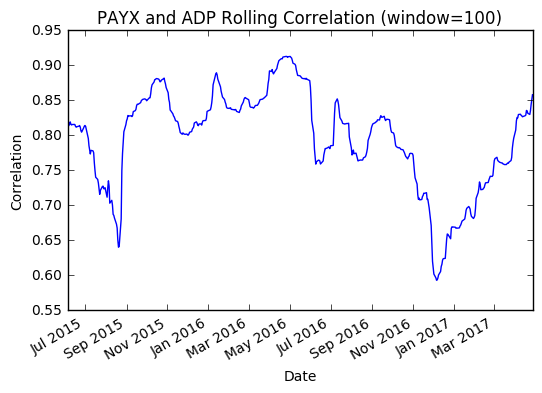

In [22]:
#plot a sample rolling correlation
sA = "PAYX"
sB = "ADP"
correls.loc[:,sA,sB].plot()
plt.ylabel('Correlation');
plt.title('%s and %s Rolling Correlation (window=%d)'%(sA, sB, window));
print "mean=%f and standard deviation=%f"%(correls.loc[:,sA,sB].mean(), correls.loc[:,sA,sB].std())

As you can see, even for PAYX and ADP (the two stocks in the S&PIT index with the highest correlation) the correlation between them can fluctuate quick a bit. Much more detailed analyses can be done trying to model/exploit these correlations. 

## Conclusion
This notebook presents some basic tools that are useful for analyzing stock correlations/clustering. The full ipython notebook can be downloaded from my github repository <a href="https://github.com/silburt/Machine_Learning/blob/master/StockCorrelation.ipynb">here</a>.

Some useful links I found when making this notebook:  
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/  
http://www.alastairsanderson.com/projects/Dow-Jones-Industrial-Average-stock-clustering-analysis/
http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html